<a href="https://colab.research.google.com/github/darja/NeuralUni/blob/master/07_segmentation_light_ryazhskikh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Сегментация изображений

Есть [фреймворк моделей сегментации](https://github.com/qubvel/segmentation_models). Обучить сеть Unet или на одном из следующих датасетов:
* [Cityscapes](https://www.cityscapes-dataset.com/) 
* https://drive.google.com/file/d/0B0d9ZiqAgFkiOHR1NTJh.. 

# Подготовка окружения

In [2]:
!pip install segmentation-models

    100% |████████████████████████████████| 51kB 1.9MB/s 
    100% |████████████████████████████████| 81kB 5.5MB/s 


In [0]:
from segmentation_models import Unet
from segmentation_models.backbones import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

import matplotlib.pyplot as plt

import tensorflow.image as img
from keras.preprocessing import image
from IPython.display import Image
from keras.utils import to_categorical
import glob
import imageio

# Утилиты
def read_image(filename):
    return imageio.imread(filename)

def display_image(filename):
    with open(filename,'rb') as f:
        display(Image(data=f.read(), format='png'))

# Подготовка входных данных

## Подготовка файловой структуры

In [3]:
!unzip dataset1.zip

Archive:  dataset1.zip
   creating: dataset1/
   creating: dataset1/annotations_prepped_test/
 extracting: dataset1/annotations_prepped_test/0016E5_08085.png  
 extracting: dataset1/annotations_prepped_test/0016E5_08039.png  
 extracting: dataset1/annotations_prepped_test/0016E5_07995.png  
 extracting: dataset1/annotations_prepped_test/0016E5_08067.png  
 extracting: dataset1/annotations_prepped_test/0016E5_08073.png  
  inflating: dataset1/annotations_prepped_test/0016E5_08123.png  
  inflating: dataset1/annotations_prepped_test/0016E5_08159.png  
  inflating: dataset1/annotations_prepped_test/0016E5_08157.png  
 extracting: dataset1/annotations_prepped_test/0016E5_08047.png  
 extracting: dataset1/annotations_prepped_test/0016E5_08075.png  
  inflating: dataset1/annotations_prepped_test/0016E5_08121.png  
 extracting: dataset1/annotations_prepped_test/0016E5_08053.png  
  inflating: dataset1/annotations_prepped_test/0016E5_08119.png  
  inflating: dataset1/annotations_prepped_test/0

In [0]:
!mkdir train_images
!mv dataset1/images_prepped_train train_images

!mkdir train_annotations
!mv dataset1/annotations_prepped_train train_annotations

!mkdir test_images
!mv dataset1/images_prepped_test test_images

!mkdir test_annotations
!mv dataset1/annotations_prepped_test test_annotations

## Входные параметры

In [0]:
# Пути к изображениям
train_image_dir = 'train_images'
train_annotation_dir = 'train_annotations'

test_image_dir = 'test_images'
test_annotation_dir = 'test_annotations'

image_files = glob.glob(train_image_dir + "/images_prepped_train/*.png") 
annotation_files = glob.glob(train_annotation_dir + "/annotations_prepped_train/*.png") 

# Размеры изображений
image_height, image_width = 360, 480
target_height, target_width = 352, 480

orig_size = (image_height, image_width)
target_size = (target_height, target_width)
target_shape = (target_height, target_width, 3)

# Типы сегментов
num_classes = 12

# Другое
batch_size = 16

## Просмотр изображений

train_images/images_prepped_train/0016E5_05040.png


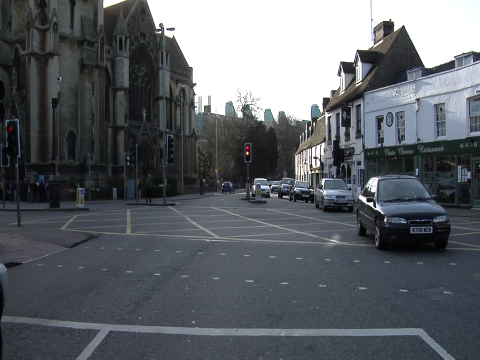

(360, 480, 3)
train_annotations/annotations_prepped_train/0016E5_05040.png


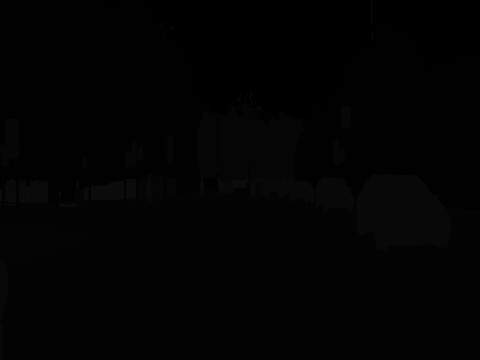

(360, 480)


In [199]:
idx = 5

# Image
filename = image_files[idx]
print(filename)
display_image(filename)

content = read_image(filename)
print(content.shape)

# Annotation
filename = annotation_files[idx]
print(filename)
with open(filename,'rb') as f:
    display(Image(data=f.read(), format='png'))

ann = read_image(filename)
print(ann.shape)

## Генератор входных изображений

In [0]:
def crop(batch_images): 
    dh = (image_height - target_height) // 2
    dw = (image_width - target_width) // 2   
    return batch_images[:, dh:(image_height - dh), dw:(image_width - dw),:]

def prepare_image(image):
    return crop(image)

def prepare_label(label):
    label = crop(label)
    label = label[:,:,:,0]
    label = to_categorical(label, num_classes = num_classes)
    return label

def create_generator(args, folder, seed):
    return ImageDataGenerator(**args).flow_from_directory(
        folder,
        target_size = orig_size,
        batch_size = batch_size,
        class_mode=None,
        seed = seed)

def train_generator():
    seed = 100
    image_generator = create_generator(dict(rescale = 1. / 255), train_image_dir, seed)
    label_generator = create_generator(dict(), train_annotation_dir, seed)
    
    combined = zip(image_generator, label_generator)
    
    for image, label in combined:
        yield (prepare_image(image), prepare_label(label))
        

# Создание и тренировка нейросети

In [56]:
model = Unet('resnet34', input_shape=target_shape, encoder_weights='imagenet', classes=num_classes, activation='softmax')
model.compile('Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.summary()

history = model.fit_generator(
    train_generator(),
    epochs = 5,
    steps_per_epoch = 100, #len(image_files) / batch_size,
    verbose = 1
)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 352, 480, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 352, 480, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_171 (ZeroPadding (None, 358, 486, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 176, 240, 64) 9408        zero_padding2d_171[0][0]         
__________________________________________________________________________________________________
bn0 (Batch

# Демонстрация работы

In [0]:
colors = [
    [255, 0, 0],
    [0, 255, 0],
    [0, 0, 255],
    [125, 125, 0],
    [0, 125, 125],
    [125, 0, 125],
    [125, 255, 0],
    [0, 125, 255],
    [125, 0, 255],
    [255, 125, 0],
    [255, 0, 125],
    [0, 255, 125]
]

def predict_single_image(content):
    x = content
    x = np.expand_dims(x, axis=0)
    x = crop(x)
    
    prediction = model.predict(x)
    segmented = np.argmax(prediction, axis=-1)
    return segmented

def save_segmented(segmented, filename):
    shape = segmented.shape
    target_shape = (shape[1], shape[2], 3)
    print("Target shape: ", target_shape)
    segmented = np.reshape(segmented, shape[0] * shape[1] * shape[2])
    
    rgb = map(lambda x: colors[x], segmented)
    rgb = np.array(list(rgb))
    rgb = np.reshape(rgb, target_shape)
    
    imageio.imwrite(filename, rgb)
    
def extract_classes(pic):
    unique, counts = np.unique(pic, return_counts = True)
    
def predict_and_demonstrate(idx):
    predicted_filename = "%s_predicted.jpg" % idx
    annotated_filename = "%s_annotated.jpg" % idx
    
    # source
    source_image_filename = image_files[idx]
    content = read_image(source_image_filename)

    # annnotation
    source_annotation_filename = annotation_files[idx]
    ann = read_image(source_annotation_filename)
    ann_prepared = np.expand_dims(ann, axis = 0)
    save_segmented(ann_prepared, annotated_filename)
    
    prediction = predict_single_image(content)
    save_segmented(prediction, predicted_filename)
    
    print("Source")
    display_image(source_image_filename)
    
    print("Expected")
    display_image(annotated_filename)
    
    print("Actual")
    display_image(predicted_filename)
    
    # classes counts in original and predicted
    print("Classes counts")
    unique, counts = np.unique(ann, return_counts = True)
    plt.plot(counts, label = "Original")  # arguments are passed to np.histogram

    unique, counts = np.unique(prediction, return_counts = True)
    plt.plot(counts, label = "Predicted") 

    plt.legend()
    plt.show()

Target shape:  (360, 480, 3)


Target shape:  (352, 480, 3)
Source


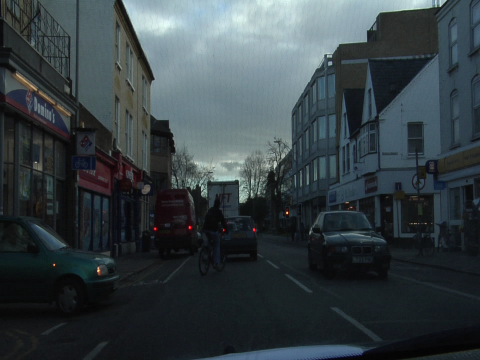

Expected


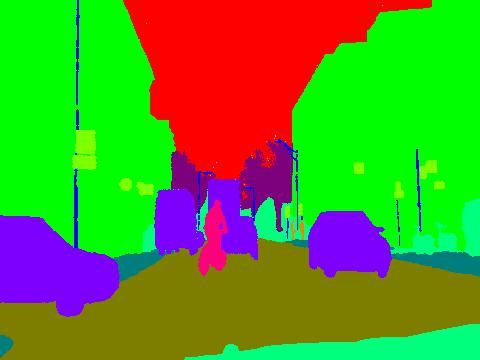

Actual


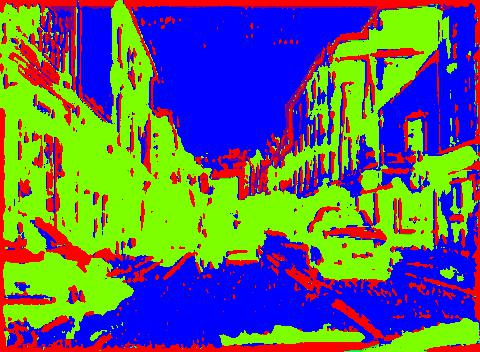

Classes counts


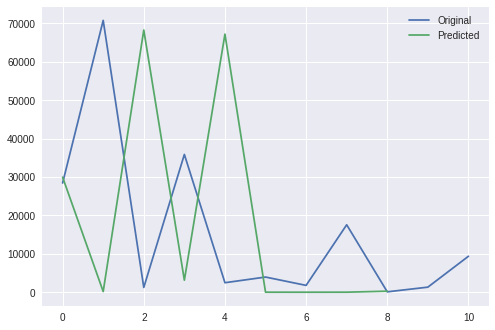

In [58]:
predict_and_demonstrate(8)